In [1]:
#Pytket imports
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
from pytket.circuit import CircBox
from pytket.passes import DecomposeBoxes
from pytket.utils import compare_unitaries

#My imports
from qft_setup import build_qft, build_inverse_qft
from utils_checks import qft_unitary , qft_unitary_dag


In [2]:
anc_qubits=5 # How many qubits are we going to use to estimate the phase?
phase_input=4/5 # our phase we want to estimate

shots=1000 #How many shots in our experiment?

In [3]:
compare_unitaries(build_inverse_qft(3).get_unitary(),qft_unitary_dag(3)) #check that inverse QFT is implemented correctly

True

In [4]:
inv_qft_box=CircBox(build_inverse_qft(anc_qubits))
qft_box=CircBox(build_qft(anc_qubits))

In [5]:
def build_phase_est_circ(n_ancillas,test_phase, state=Circuit(1)): #here state= Circuit(1) for sq gates
    phase_circ = Circuit(n_ancillas+len(state.qubits),n_ancillas)
    
    phase_circ.X(n_ancillas)
    
    for j in range(n_ancillas):
        phase_circ.H(j)
        
    for k in range(n_ancillas):
        for l in range(2**k):
            phase_circ.add_gate(OpType.CU1,test_phase,[n_ancillas - 1 - k, n_ancillas])
                                 
            
    #phase_circ.add_barrier([x for x in range(n_ancillas+1)])  
    
    #phase_circ.append(build_inverse_qft(n_ancillas)) #append inverse qft as gates
    
    phase_circ.add_circbox(inv_qft_box, [x for x in range(n_ancillas)] ,opgroup="Inverse QFT") #append inverse qft as a box
    
    
    #phase_circ.add_barrier([x for x in range(n_ancillas+1)])
    
    for m in range(n_ancillas):
        phase_circ.Measure(m,m)
        
    return phase_circ


In [6]:
est_phase = build_phase_est_circ(anc_qubits , phase_input)

render_circuit_jupyter(est_phase)

In [7]:
DecomposeBoxes().apply(est_phase)

render_circuit_jupyter(est_phase)

In [8]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

guadalupe_backend = IBMQEmulatorBackend('ibmq_guadalupe', hub='partner-cqc', group='internal', project='default')
compiled_circ=guadalupe_backend.get_compiled_circuit(est_phase)
render_circuit_jupyter(compiled_circ)
print("Number of gates in Circuit: ", compiled_circ.n_gates)
print("Number of CX gates in Circuit: ", compiled_circ.n_gates_of_type(OpType.CX))

/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (138180.78626786184 > 2 * 68992.79562832476). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (138180.78626786184 > 2 * 68992.79562832476). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (138180.78626786184 > 2 * 68992.79562832476). Truncating to maximum value

Number of gates in Circuit:  245
Number of CX gates in Circuit:  118


In [9]:
handle = guadalupe_backend.process_circuit(compiled_circ, shots)
my_result=guadalupe_backend.get_result(handle)
my_result.get_counts() 

Counter({(0, 0, 0, 0, 0): 29,
         (0, 0, 0, 0, 1): 20,
         (0, 0, 0, 1, 0): 13,
         (0, 0, 0, 1, 1): 8,
         (0, 0, 1, 0, 0): 40,
         (0, 0, 1, 0, 1): 49,
         (0, 0, 1, 1, 0): 23,
         (0, 0, 1, 1, 1): 16,
         (0, 1, 0, 0, 0): 24,
         (0, 1, 0, 0, 1): 31,
         (0, 1, 0, 1, 0): 20,
         (0, 1, 0, 1, 1): 30,
         (0, 1, 1, 0, 0): 120,
         (0, 1, 1, 0, 1): 187,
         (0, 1, 1, 1, 0): 48,
         (0, 1, 1, 1, 1): 22,
         (1, 0, 0, 0, 0): 50,
         (1, 0, 0, 0, 1): 26,
         (1, 0, 0, 1, 0): 16,
         (1, 0, 0, 1, 1): 7,
         (1, 0, 1, 0, 0): 36,
         (1, 0, 1, 0, 1): 32,
         (1, 0, 1, 1, 0): 16,
         (1, 0, 1, 1, 1): 9,
         (1, 1, 0, 0, 0): 23,
         (1, 1, 0, 0, 1): 11,
         (1, 1, 0, 1, 0): 8,
         (1, 1, 0, 1, 1): 7,
         (1, 1, 1, 0, 0): 28,
         (1, 1, 1, 0, 1): 32,
         (1, 1, 1, 1, 0): 11,
         (1, 1, 1, 1, 1): 8})

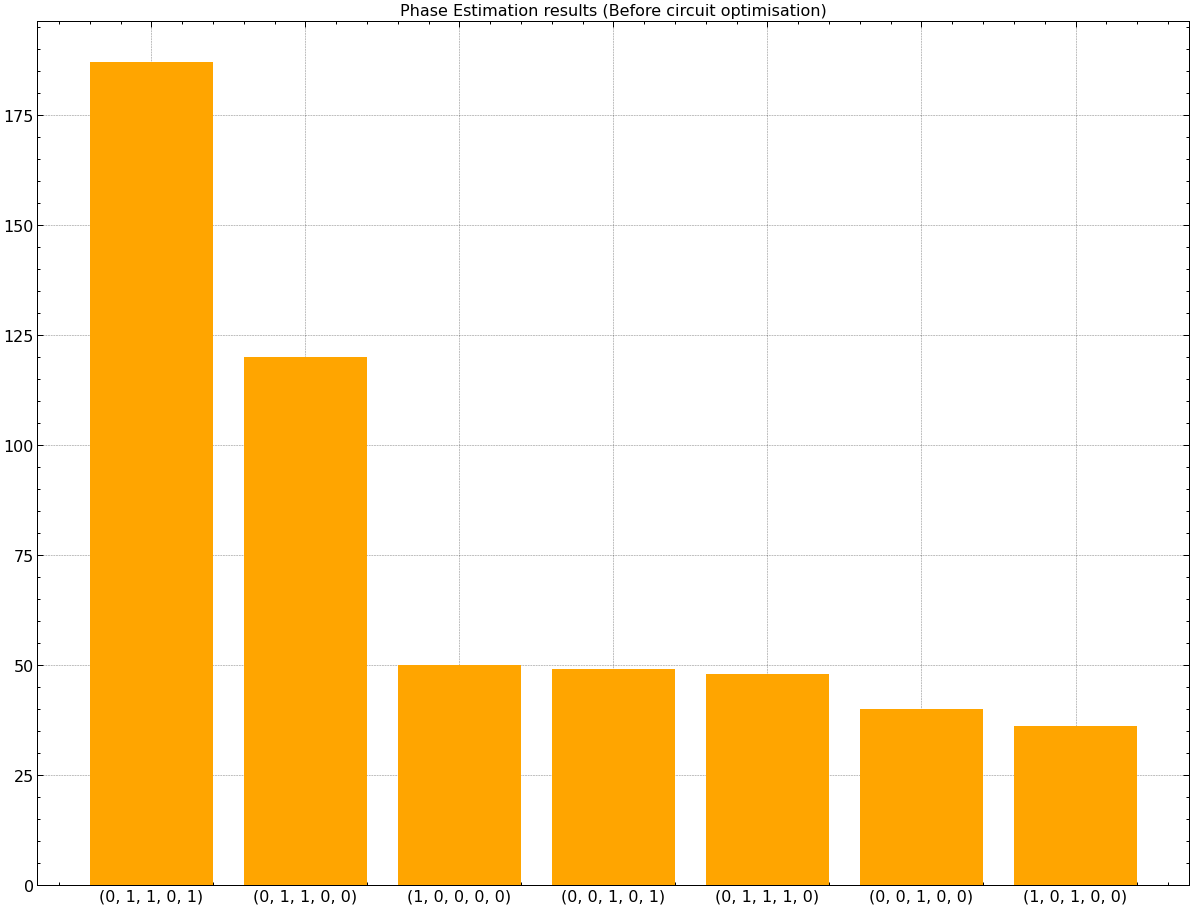

('success ratio = ', 0.187, 'max_value =', 187)

In [10]:
from plotting import plot_results

rank_number = 7 # choose the number of basis states to include in the plot. For n_qubits there could be 2**n

plot_results(my_result, rank = rank_number, title = 'Phase Estimation results (Before circuit optimisation)')

In [11]:
from pytket.passes import (
    SequencePass,
    RebaseCustom,
    CXMappingPass,
    FullPeepholeOptimise,
    RemoveRedundancies,
)

from pytket.placement import NoiseAwarePlacement

guadalupe_info = guadalupe_backend.backend_info
guadalupe_placer = NoiseAwarePlacement(arc=guadalupe_info.architecture,
                                       node_errors=guadalupe_info.averaged_node_gate_errors,
                                       link_errors=guadalupe_info.averaged_edge_gate_errors,
                                       readout_errors=guadalupe_info.averaged_readout_errors)


guadalupe_mapping_pass = CXMappingPass(
    guadalupe_info.architecture,
    guadalupe_placer,
    directed_cx=False
)

from pytket.passes import auto_rebase_pass

ibm_rebase = auto_rebase_pass({OpType.CX, OpType.X, OpType.SX, OpType.Rz})

In [12]:
sequence_pass = SequencePass([FullPeepholeOptimise(), guadalupe_mapping_pass, ibm_rebase, RemoveRedundancies()])
sequence_pass.apply(compiled_circ)

#guadalupe_backend.default_compilation_pass(2).apply(compiled_circ)

print("Number of gates in Circuit: ", compiled_circ.n_gates)
print("Number of CX gates in Circuit: ", compiled_circ.n_gates_of_type(OpType.CX))

render_circuit_jupyter(compiled_circ)

Number of gates in Circuit:  172
Number of CX gates in Circuit:  60


In [13]:
handle = guadalupe_backend.process_circuit(compiled_circ, shots)
my_result_opt=guadalupe_backend.get_result(handle)
my_result_opt.get_counts() #display counts for optimised circuit

Counter({(0, 0, 0, 0, 0): 12,
         (0, 0, 0, 0, 1): 2,
         (0, 0, 0, 1, 0): 4,
         (0, 0, 0, 1, 1): 2,
         (0, 0, 1, 0, 0): 14,
         (0, 0, 1, 0, 1): 51,
         (0, 0, 1, 1, 0): 5,
         (0, 0, 1, 1, 1): 8,
         (0, 1, 0, 0, 0): 20,
         (0, 1, 0, 0, 1): 36,
         (0, 1, 0, 1, 0): 13,
         (0, 1, 0, 1, 1): 19,
         (0, 1, 1, 0, 0): 167,
         (0, 1, 1, 0, 1): 404,
         (0, 1, 1, 1, 0): 26,
         (0, 1, 1, 1, 1): 18,
         (1, 0, 0, 0, 0): 41,
         (1, 0, 0, 0, 1): 18,
         (1, 0, 0, 1, 0): 1,
         (1, 0, 0, 1, 1): 3,
         (1, 0, 1, 0, 0): 17,
         (1, 0, 1, 0, 1): 22,
         (1, 0, 1, 1, 0): 1,
         (1, 0, 1, 1, 1): 1,
         (1, 1, 0, 0, 0): 7,
         (1, 1, 0, 0, 1): 12,
         (1, 1, 0, 1, 1): 2,
         (1, 1, 1, 0, 0): 30,
         (1, 1, 1, 0, 1): 35,
         (1, 1, 1, 1, 0): 5,
         (1, 1, 1, 1, 1): 4})

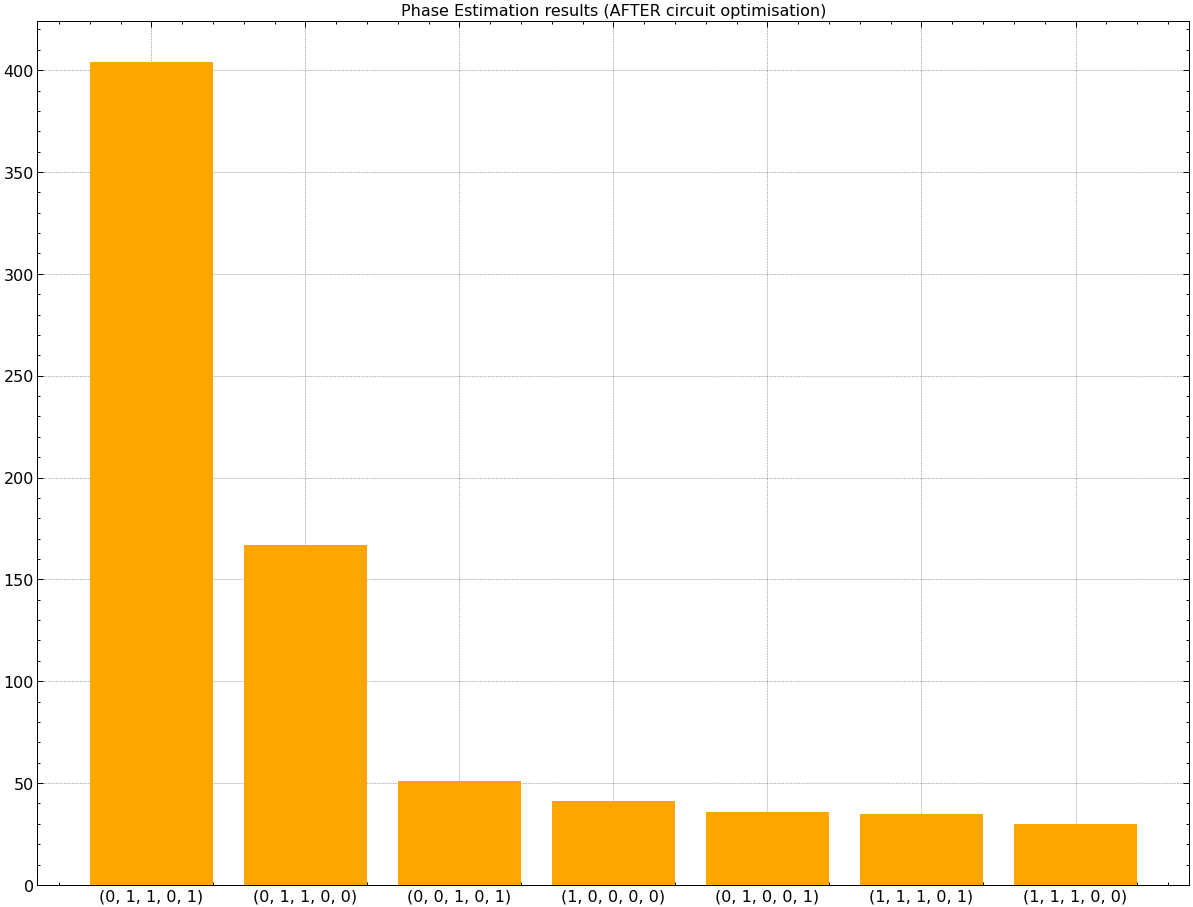

('success ratio = ', 0.404, 'max_value =', 404)

In [14]:
plot_results(my_result_opt, rank = rank_number , title = 'Phase Estimation results (AFTER circuit optimisation)')

In [15]:
#most probable basis state result as a tuple
max_key = max(my_result_opt.get_counts(), key = my_result_opt.get_counts().get)

#convert this tuple to a string
def tuple_to_string(my_tuple): #(1,0,0) -> '100'
    mystring = ''
    for entry in my_tuple :
        mystring += str(entry)
        
    return mystring

highest_probability_string = tuple_to_string(max_key)

decimal_output = int(highest_probability_string,2) #convert from binary string to a decimal
        
phase_estimate = decimal_output/(2**anc_qubits)

naive_error=round(abs(phase_estimate-phase_input/2),4)

def percentage_error(error):
    percentage=round( 2*error/phase_input *100, 1 ) #percentage error rounded to 1dp
    print( "Naive error percentage = {}%".format(percentage))



In [16]:
# Our "winning" basis state
highest_probability_string

'01101'

In [17]:
decimal_output # =d  Divide this by 2**anc_qubits to get phase

13

In [18]:
#This is our phase estimate... Ideally it should equal phase_input/2
phase_estimate

0.40625

In [19]:
#expected answer
phase_input/2

0.4

In [20]:
naive_error # how much did we miss our expected result by? absolute value to 4dp

0.0062

In [21]:
percentage_error(naive_error) # 1dp

Naive error percentage = 1.5%
